# TIFF Image Analysis Notebook

This notebook demonstrates how to open, analyze, and display TIFF images using Python libraries like rasterio, matplotlib, and PIL.

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from PIL import Image
import os
import glob

# Set up matplotlib for better display
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

In [3]:
# Function to find TIFF files in the current workspace
def find_tiff_files(directory=".", recursive=True):
    """
    Find all TIFF files in the specified directory
    
    Parameters:
    directory (str): Directory to search in
    recursive (bool): Whether to search recursively
    
    Returns:
    list: List of TIFF file paths
    """
    if recursive:
        tiff_patterns = ['**/*.tif', '**/*.tiff', '**/*.TIF', '**/*.TIFF']
        tiff_files = []
        for pattern in tiff_patterns:
            tiff_files.extend(glob.glob(os.path.join(directory, pattern), recursive=True))
    else:
        tiff_patterns = ['*.tif', '*.tiff', '*.TIF', '*.TIFF']
        tiff_files = []
        for pattern in tiff_patterns:
            tiff_files.extend(glob.glob(os.path.join(directory, pattern)))
    
    return sorted(list(set(tiff_files)))

# Find TIFF files in the workspace
workspace_dir = "/Users/gasper/Documents/ViCos/eo_cd_slo/cluster/images/tiff_files"
tiff_files = find_tiff_files(workspace_dir)

print(f"Found {len(tiff_files)} TIFF files:")
for i, file in enumerate(tiff_files[:10]):  # Show first 10 files
    print(f"{i+1}. {file}")
if len(tiff_files) > 10:
    print(f"... and {len(tiff_files) - 10} more files")

Found 1 TIFF files:
1. /Users/gasper/Documents/ViCos/eo_cd_slo/cluster/images/tiff_files/sentinel2_grid_463_2023_08.tiff


In [4]:
# Function to analyze TIFF file metadata
def analyze_tiff_metadata(file_path):
    """
    Analyze and display metadata of a TIFF file
    
    Parameters:
    file_path (str): Path to the TIFF file
    """
    try:
        with rasterio.open(file_path) as src:
            print(f"File: {os.path.basename(file_path)}")
            print(f"Driver: {src.driver}")
            print(f"Width: {src.width} pixels")
            print(f"Height: {src.height} pixels")
            print(f"Number of bands: {src.count}")
            print(f"Data type: {src.dtypes[0]}")
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            print(f"Bounds: {src.bounds}")
            if src.nodata is not None:
                print(f"No data value: {src.nodata}")
            print("-" * 50)
            
            return True
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return False

In [5]:
# Function to display TIFF images
def display_tiff_image(file_path, band=None, cmap='viridis', title=None):
    """
    Display a TIFF image using matplotlib
    
    Parameters:
    file_path (str): Path to the TIFF file
    band (int): Band number to display (1-indexed). If None, displays RGB composite or first band
    cmap (str): Colormap for single-band images
    title (str): Title for the plot
    """
    try:
        with rasterio.open(file_path) as src:
            if title is None:
                title = f"{os.path.basename(file_path)}"
            
            fig, ax = plt.subplots(figsize=(12, 8))
            
            if band is not None:
                # Display specific band
                data = src.read(band)
                im = ax.imshow(data, cmap=cmap)
                ax.set_title(f"{title} - Band {band}")
                plt.colorbar(im, ax=ax, shrink=0.8)
            elif src.count >= 3:
                # Display RGB composite (assuming bands 1,2,3 are RGB)
                rgb = np.dstack([src.read(i) for i in [1, 2, 3]])
                # Normalize to 0-1 range if needed
                if rgb.max() > 1:
                    rgb = rgb / rgb.max()
                ax.imshow(rgb)
                ax.set_title(f"{title} - RGB Composite")
            else:
                # Display first band
                data = src.read(1)
                im = ax.imshow(data, cmap=cmap)
                ax.set_title(f"{title} - Band 1")
                plt.colorbar(im, ax=ax, shrink=0.8)
            
            ax.set_xlabel('X (pixels)')
            ax.set_ylabel('Y (pixels)')
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Error displaying {file_path}: {e}")

In [6]:
# Function to display histogram of image values
def plot_histogram(file_path, band=1, bins=50):
    """
    Plot histogram of pixel values for a specific band
    
    Parameters:
    file_path (str): Path to the TIFF file
    band (int): Band number to analyze (1-indexed)
    bins (int): Number of histogram bins
    """
    try:
        with rasterio.open(file_path) as src:
            data = src.read(band)
            
            # Remove no-data values if they exist
            if src.nodata is not None:
                data = data[data != src.nodata]
            
            # Flatten the array and remove any remaining NaN or infinite values
            data_flat = data.flatten()
            data_flat = data_flat[np.isfinite(data_flat)]
            
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.hist(data_flat, bins=bins, alpha=0.7, edgecolor='black')
            ax.set_title(f'Histogram of Pixel Values - {os.path.basename(file_path)} (Band {band})')
            ax.set_xlabel('Pixel Value')
            ax.set_ylabel('Frequency')
            ax.grid(True, alpha=0.3)
            
            # Add statistics
            mean_val = np.mean(data_flat)
            std_val = np.std(data_flat)
            min_val = np.min(data_flat)
            max_val = np.max(data_flat)
            
            stats_text = f'Mean: {mean_val:.2f}\nStd: {std_val:.2f}\nMin: {min_val:.2f}\nMax: {max_val:.2f}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Error plotting histogram for {file_path}: {e}")

## Load and Analyze a Specific TIFF File

Choose a TIFF file to analyze by setting the `tiff_file_path` variable below:

In [7]:
# Select a TIFF file to analyze
# Option 1: Use the first found TIFF file
if tiff_files:
    tiff_file_path = tiff_files[0]
    print(f"Selected file: {tiff_file_path}")
else:
    # Option 2: Manually specify a TIFF file path
    tiff_file_path = "/path/to/your/image.tif"  # Change this to your TIFF file path
    print(f"Using manually specified file: {tiff_file_path}")

# Option 3: Uncomment and modify the line below to use a specific file
# tiff_file_path = "/Users/gasper/Documents/ViCos/eo_cd_slo/data/your_image.tif"

Selected file: /Users/gasper/Documents/ViCos/eo_cd_slo/cluster/images/tiff_files/sentinel2_grid_463_2023_08.tiff


In [8]:
# Analyze the metadata of the selected TIFF file
if os.path.exists(tiff_file_path):
    print("=== TIFF File Metadata ===")
    analyze_tiff_metadata(tiff_file_path)
else:
    print(f"File not found: {tiff_file_path}")
    print("Please update the tiff_file_path variable with a valid file path.")

=== TIFF File Metadata ===
File: sentinel2_grid_463_2023_08.tiff
Driver: GTiff
Width: 726 pixels
Height: 505 pixels
Number of bands: 3
Data type: int16
CRS: EPSG:4326
Transform: | 0.00, 0.00, 14.34|
| 0.00,-0.00, 46.17|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=14.34286538383303, bottom=46.12350714464384, right=14.408205383833028, top=46.16895714464384)
No data value: -32768.0
--------------------------------------------------


=== Displaying TIFF Image ===


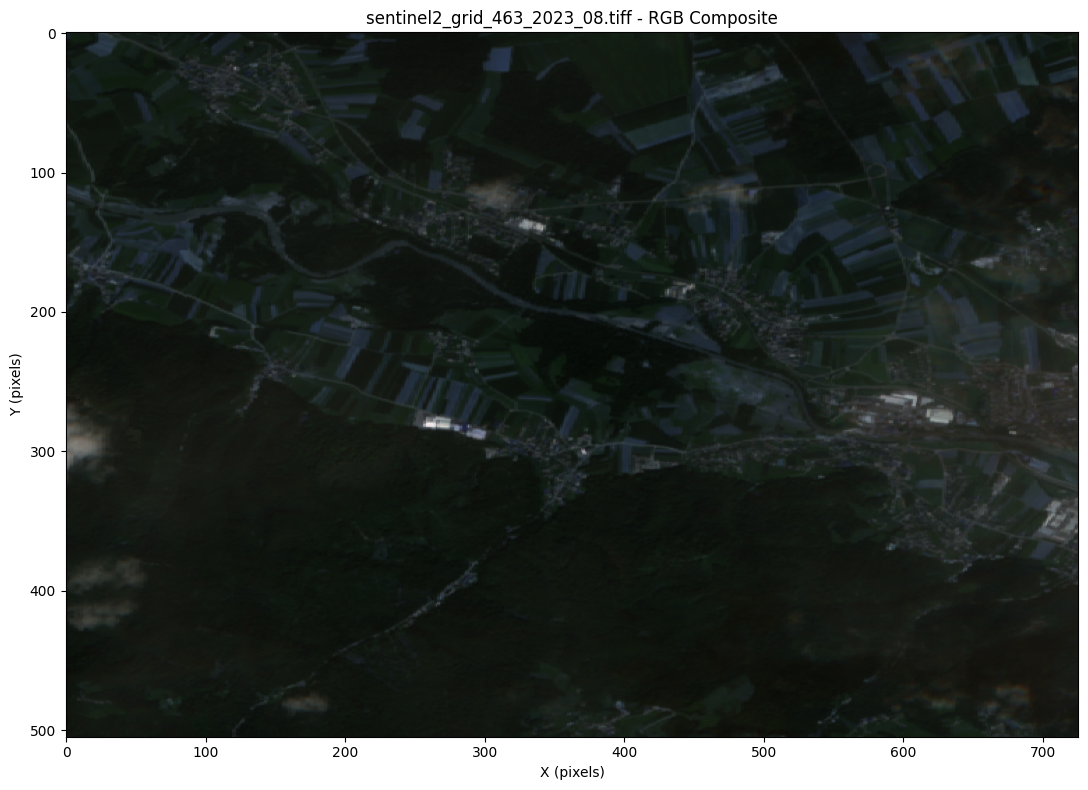

In [9]:
# Display the TIFF image
if os.path.exists(tiff_file_path):
    print("=== Displaying TIFF Image ===")
    display_tiff_image(tiff_file_path)
else:
    print(f"Cannot display image: File not found at {tiff_file_path}")

=== Pixel Value Histogram ===


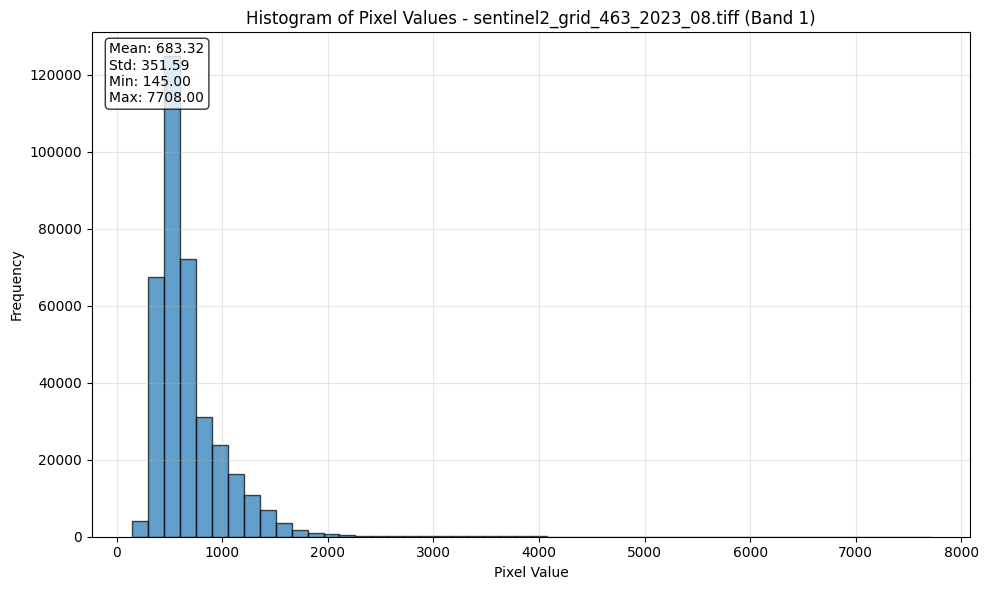

In [10]:
# Plot histogram of pixel values
if os.path.exists(tiff_file_path):
    print("=== Pixel Value Histogram ===")
    plot_histogram(tiff_file_path, band=1)
else:
    print(f"Cannot plot histogram: File not found at {tiff_file_path}")

## Additional Analysis Options

You can perform additional analysis by:

1. **Display specific bands**: Use `display_tiff_image(tiff_file_path, band=2)` to display band 2
2. **Change colormap**: Use `display_tiff_image(tiff_file_path, cmap='gray')` for grayscale
3. **Analyze different bands**: Use `plot_histogram(tiff_file_path, band=2)` for band 2 histogram
4. **Load multiple files**: Modify the `tiff_file_path` variable to analyze different files

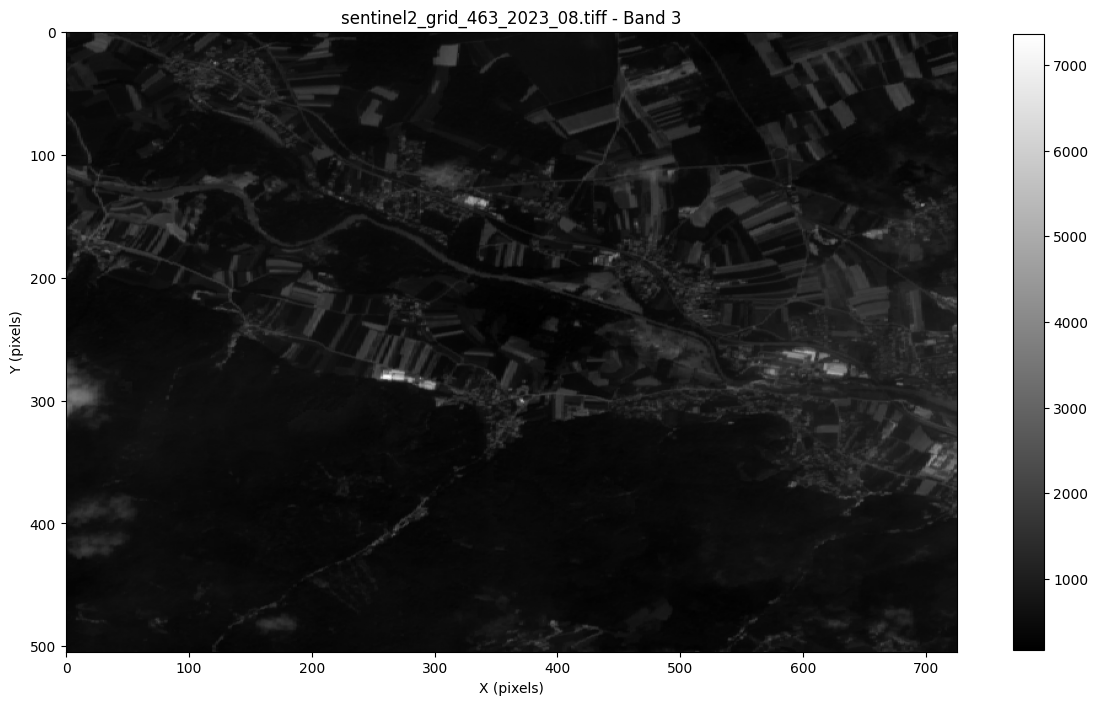

In [13]:
# Experiment with different display options here
# Uncomment and modify these lines as needed:

# Display a specific band with grayscale colormap
display_tiff_image(tiff_file_path, band=3, cmap='gray')

# Display with different colormaps
# display_tiff_image(tiff_file_path, band=1, cmap='plasma')
# display_tiff_image(tiff_file_path, band=1, cmap='coolwarm')

# Analyze different bands
# plot_histogram(tiff_file_path, band=2, bins=100)

# Load and analyze a different file
# another_file = "/path/to/another/image.tif"
# if os.path.exists(another_file):
#     display_tiff_image(another_file)
#     plot_histogram(another_file)